<a href="https://colab.research.google.com/github/SamiaHub/energy/blob/main/MODELO_SARIMA_CLUSTER_15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn
!pip install statsmodels
!pip install pandas


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit

In [ ]:
# Cargamos primero el contenido de nuestro Drive
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Cargamos el conjunto de datos y lo definimos dentro del nombre df ( dataframe de pandas)

df = pd.read_csv('/content/drive/MyDrive/cluster15.csv', delimiter=';',parse_dates=['ds'], date_parser=lambda x: pd.to_datetime(x, format='%Y-%m-%d_%H'))

#leo los heads de mi dataframe para validar que se haya cargado correctamente
df.head()

<ipython-input-5-b8773c8e4b89>:3: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv('/content/drive/MyDrive/cluster15.csv', delimiter=';',parse_dates=['ds'], date_parser=lambda x: pd.to_datetime(x, format='%Y-%m-%d_%H'))


,ds,y
0,2009-07-15 00:00:00,1.090514
1,2009-07-15 01:00:00,0.781937
2,2009-07-15 02:00:00,0.595129
3,2009-07-15 03:00:00,0.531196
4,2009-07-15 04:00:00,0.502776


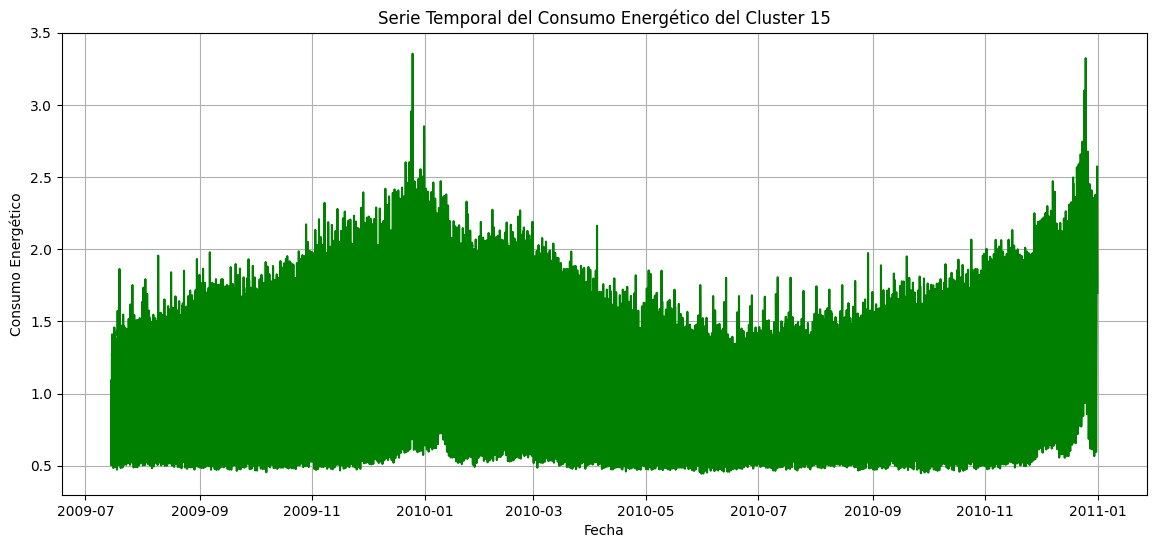

In [ ]:
# Vamos a visualizar como se compone la serie temporal de este cluster
plt.figure(figsize=(14, 6))
plt.plot(df['ds'], df['y'], color='green')
plt.title('Serie Temporal del Consumo Energético del Cluster 15')
plt.xlabel('Fecha')
plt.ylabel('Consumo Energético')
plt.grid(True)
plt.show()

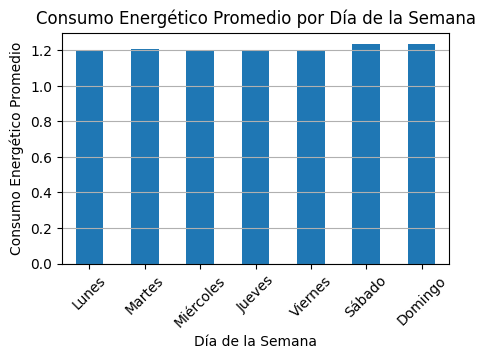

In [ ]:
# Para visualizar más claro los datos
#vamos a agrupar los datos por día de la semana y calcular la media del consumo energético
day_of_week_avg_consumption = df.groupby(df['ds'].dt.dayofweek)['y'].mean()

# Plot del consumo energético promedio por día de la semana
plt.figure(figsize=(5, 3))
day_of_week_avg_consumption.plot(kind='bar')
plt.title('Consumo Energético Promedio por Día de la Semana')
plt.xlabel('Día de la Semana')
plt.ylabel('Consumo Energético Promedio')
plt.xticks(range(7), ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo'], rotation=45)
plt.grid(axis='y')
plt.show()

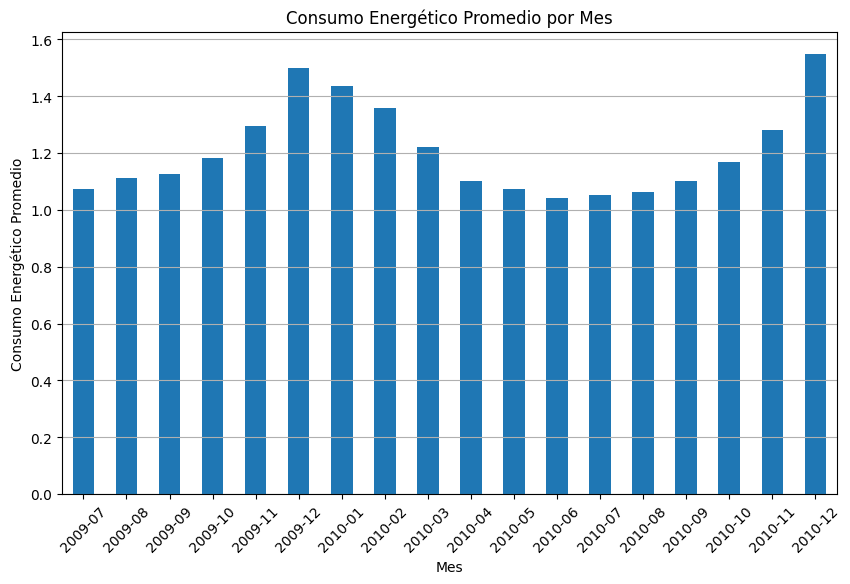

In [ ]:
#ahora vamos a visualizarlos por mes del año
#Para ello debemos primero agrupar los datos por mes y calcular la media del consumo energético
monthly_avg_consumption = df.groupby(df['ds'].dt.to_period('M'))['y'].mean()


# Plot del consumo energético promedio por mes
plt.figure(figsize=(10, 6))
monthly_avg_consumption.plot(kind='bar')
plt.title('Consumo Energético Promedio por Mes')
plt.xlabel('Mes')
plt.ylabel('Consumo Energético Promedio')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

**DIVISION DEL MODELO ENTRE EL CONJUNTO DE PRUEBA Y ENTRENAMIENTO

Aplicaremos la técnica de división de datos entre conjunto de prueba y entrenamiento mediante validación cruzada donde iteraremos cada 4 splits nuestros datos

In [ ]:
tscv = TimeSeriesSplit(n_splits=4)
for train_index, test_index in tscv.split(df):
  train_df, test_df = df.iloc[train_index], df.iloc[test_index]



**CONSTRUCCION DEL MODELO**

Para elegir los parametros del modelo SARIMA es importante evaluar la Autocorrelación del modelo y su Autocorrelación Parcial

<Figure size 1000x600 with 0 Axes>

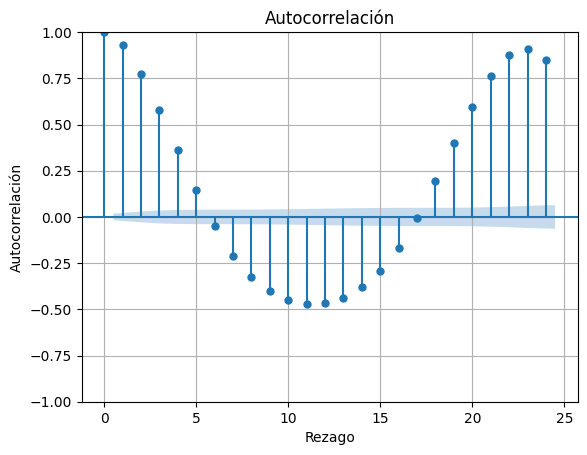

<Figure size 1000x600 with 0 Axes>

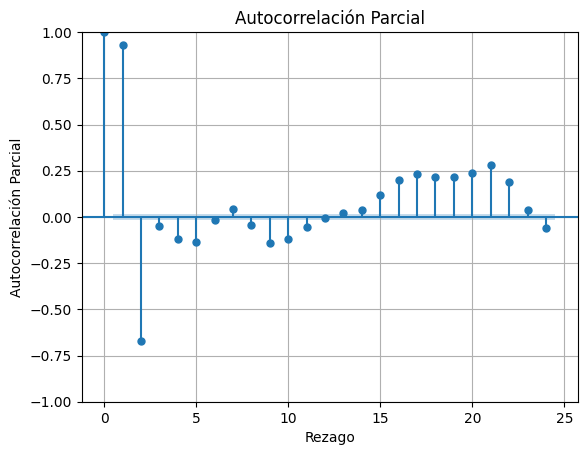

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Gráfico de Autocorrelación (ACF)
plt.figure(figsize=(10, 6))
# Ajusta el número de rezagos según tus datos
plot_acf(df['y'], lags=24)
#los lags van de acuerdo a que cada 24h inicia un nuevo día
plt.title('Autocorrelación')
plt.xlabel('Rezago')
plt.ylabel('Autocorrelación')
plt.grid(True)
plt.show()

# Gráfico de Autocorrelación Parcial (PACF)
plt.figure(figsize=(10, 6))
plot_pacf(df['y'], lags=24)
#los lags van de acuerdo a que cada 24h inicia un nuevo día
# Ajusta el número de rezagos según tus datos
plt.title('Autocorrelación Parcial')
plt.xlabel('Rezago')
plt.ylabel('Autocorrelación Parcial')
plt.grid(True)
plt.show()

Para la construcción de un modelo SARIMA es impotante que definamos los parametros del mismo siendo, conociendo muy bien cómo están distribuidos y construidos nuestros datos. Para ello anteriormente estudiamos sus plots y distribuciones.

**P (parámetro de autoregresión estacional)**: Al estar trabajando con datos horarios, las observaciones se "autoregresan" con su mismo horario del día anterior. Por ello en este modelo **P=1**.Esto se comprueba por el  **pico muy significativo en el lag(1)**


**D (parámetro de diferenciación estacional)**:los datos muestran diferencias significativas entre los diferentes días de la semana por ello en este caso no es prudente que en el modelo le quitemos la diferenciación estacional con el día anterior. Siendo **D=0**

**Q (parámetro de media móvil estacional)**: con este parámetro determinamos el número de términos de media móvil estacionales. Al colocarlo en 1 contemplamos el error de predicción de su misma hora predicha en días anteriores. **Q=1**

**S (longitud del ciclo estacional):** Los datos se encuentran con un ciclo estacional de uso horario. Siendo que tenemos datos por cada hora de las 24 horas del día definimos este parámetro cómo **S=24** Esto se comprueba con el **pico considerable en el gráfico de Autocorrelación  a las 24 h**

In [ ]:
# Vamos a contruir el modelo sobre el conjunto de entranimiento definido en el punto anterior
# Parámetros del modelo SARIMA (p, d, q)
order = (1, 1, 1)

# Parámetros estacionales del modelo SARIMA (P, D, Q, S)

seasonal_order = (1, 0, 1, 24)

model = SARIMAX(train_df['y'], order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)

#ajustamos el modelo a los datos de entrenamiento mediante la función “fit”
sarima_model = model.fit()


Empezamos a predecir con nuestro modelo SARIMA y lo probamos

In [ ]:
# Con el modelo construido vamos a realizar predicciones en el conjunto de prueba
start = test_df.index.min()
end = test_df.index.max()
sarima_pred = sarima_model.predict(start=start, end=end)

In [ ]:
#hacemos las predicciones en el conjunto de prueba
y_test = test_df['y']
y_predict = sarima_pred

**Con el modelo ya construido vamos a visualizarlo en un gráfico**

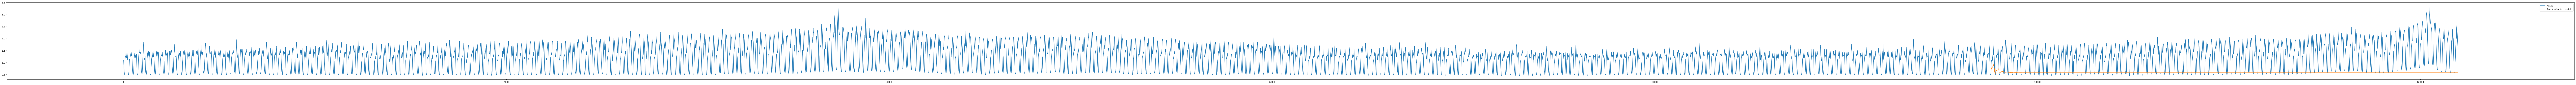

In [ ]:
#visualización del modelo
plt.figure(figsize=(200,6))
plt.plot(df['y'],label='Actual')
plt.plot(predictions,label='Predicción del modelo')
plt.legend()

**EVALUACIÓN DEL MODELO ☢**

In [ ]:
#Elegimos 3 metricas para evaluar nuestro modelo MAE , MSE y RMSE
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae = mean_absolute_error(test_df['y'], predictions)
mse = mean_squared_error(test_df['y'], predictions)
rmse = np.sqrt(mse)

print("Error Medio Absoluto (MAE):", mae)
print("Error Cuadrático Medio (MSE):", mse)
print("Raíz del Error Cuadrático Medio (RMSE):", rmse)


Error Medio Absoluto (MAE): 0.736746437073754
Error Cuadrático Medio (MSE): 0.8162872154605487
Raíz del Error Cuadrático Medio (RMSE): 0.9034861456937504


Veremos un ajuste automático para mejorar el modelo como futuros pasos.


In [ ]:
!pip install pmdarima
import pmdarima as pm

# Ajuste automático del modelo SARIMA usando auto_arima
model = pm.auto_arima(train_df['y'], seasonal=True, m=12, trace=True,
                      error_action='ignore', suppress_warnings=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=-11453.142, Time=66.18 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-5588.398, Time=1.12 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-10115.514, Time=11.10 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-9310.552, Time=19.35 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-5590.397, Time=0.33 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=-10263.738, Time=42.99 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=-10283.894, Time=22.91 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=-11101.351, Time=117.27 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=-10989.816, Time=112.37 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=-10224.590, Time=14.33 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=-10855.216, Time=109.34 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=-11046.617, Time=103.85 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=-11108.937, Time=124.81 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=-106

**CONCLUSIONES DEL MODELO**

Tenemos según estos resultados un modelos sólido para predecir el consumo de energía de este cluster. Sin embargo, para seleccionar el modelo final debemos compáralo con todos los demás modelos construidos.